# GANs For Art

## Importing the modules

In [10]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
%matplotlib inline

## Preparing the data

In [11]:
batch_size = 128
image_size = (64,64)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [12]:
transform_ds = transforms.Compose([transforms.Resize(image_size),
#                                    transforms.RandomCrop(32, padding=2),
#                                    transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

train_ds = torchvision.datasets.ImageFolder(root="Z:/ArtGenerator/Resized_color256x512",
                                     transform=transform_ds)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
print(len(train_ds))

38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])


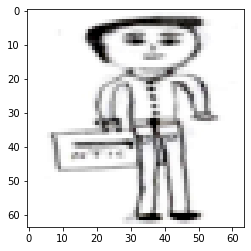

In [13]:
images,_ = train_ds[3]
print(images.size())
plt.imshow(images.permute(1,2,0))

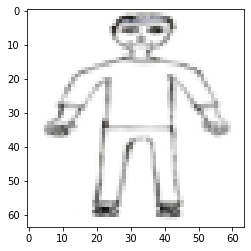

In [14]:
images,_ = train_ds[8]
plt.imshow(images.permute(1,2,0))

In [15]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [16]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

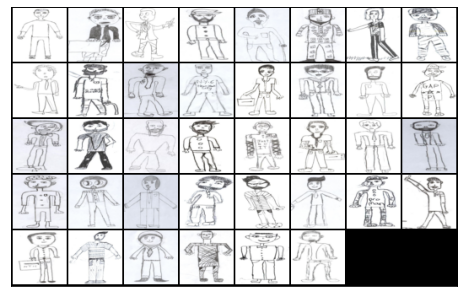

In [17]:
show_batch(train_dl)

In [18]:
torch.cuda.is_available()

True

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
device = get_default_device()
device

device(type='cuda')

In [21]:
train_dl = DeviceDataLoader(train_dl, device)

In [22]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [23]:
discriminator = to_device(discriminator, device)

In [24]:
latent_size = 150

In [25]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

## Defining the model

torch.Size([128, 3, 64, 64])


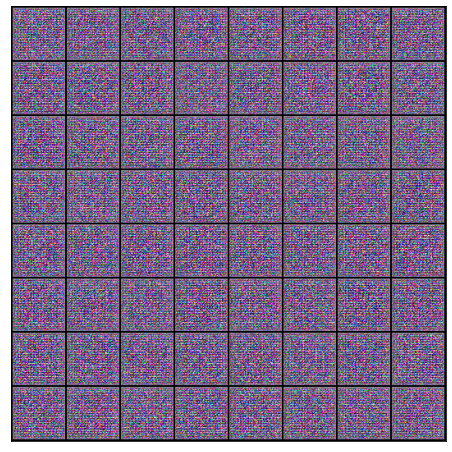

In [26]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [27]:
generator = to_device(generator, device)

In [28]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [29]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [30]:
from torchvision.utils import save_image

In [31]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [32]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [33]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


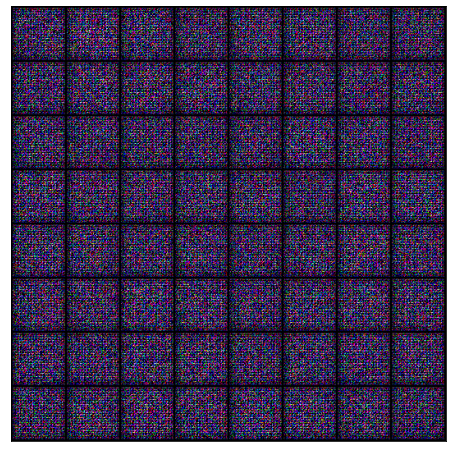

In [34]:
save_samples(0, fixed_latent)

In [35]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [36]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [37]:
lr = 0.001
epochs = 150

In [38]:
history = fit(epochs,lr)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/150], loss_g: 8.7042, loss_d: 1.4233, real_score: 0.4919, fake_score: 0.4965
Saving generated-images-0001.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/150], loss_g: 15.9874, loss_d: 5.7650, real_score: 0.9997, fake_score: 0.9965
Saving generated-images-0002.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/150], loss_g: 13.2631, loss_d: 0.2793, real_score: 0.8836, fake_score: 0.0000
Saving generated-images-0003.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/150], loss_g: 12.2072, loss_d: 0.0679, real_score: 0.9908, fake_score: 0.0564
Saving generated-images-0004.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/150], loss_g: 16.9920, loss_d: 4.3914, real_score: 0.9914, fake_score: 0.9857
Saving generated-images-0005.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/150], loss_g: 15.7525, loss_d: 0.8517, real_score: 0.5445, fake_score: 0.0000
Saving generated-images-0006.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/150], loss_g: 14.5217, loss_d: 0.0003, real_score: 0.9997, fake_score: 0.0000
Saving generated-images-0007.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/150], loss_g: 13.1502, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0008.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/150], loss_g: 10.8621, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0009.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/150], loss_g: 14.6814, loss_d: 0.4343, real_score: 1.0000, fake_score: 0.3234
Saving generated-images-0010.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/150], loss_g: 14.7647, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-0011.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/150], loss_g: 13.3677, loss_d: 0.0005, real_score: 0.9995, fake_score: 0.0000
Saving generated-images-0012.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/150], loss_g: 14.6612, loss_d: 1.2570, real_score: 0.9986, fake_score: 0.5182
Saving generated-images-0013.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/150], loss_g: 11.4763, loss_d: 0.0812, real_score: 0.9362, fake_score: 0.0002
Saving generated-images-0014.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/150], loss_g: 8.8829, loss_d: 0.1222, real_score: 0.9291, fake_score: 0.0006
Saving generated-images-0015.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/150], loss_g: 6.7377, loss_d: 0.0154, real_score: 0.9894, fake_score: 0.0041
Saving generated-images-0016.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/150], loss_g: 10.0119, loss_d: 0.8018, real_score: 0.9983, fake_score: 0.4561
Saving generated-images-0017.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/150], loss_g: 8.5545, loss_d: 0.0217, real_score: 0.9821, fake_score: 0.0030
Saving generated-images-0018.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/150], loss_g: 7.3424, loss_d: 0.0482, real_score: 0.9602, fake_score: 0.0040
Saving generated-images-0019.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/150], loss_g: 4.8922, loss_d: 0.0501, real_score: 0.9913, fake_score: 0.0398
Saving generated-images-0020.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/150], loss_g: 8.4750, loss_d: 0.2507, real_score: 0.9960, fake_score: 0.2121
Saving generated-images-0021.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/150], loss_g: 8.6094, loss_d: 0.0215, real_score: 0.9813, fake_score: 0.0019
Saving generated-images-0022.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/150], loss_g: 7.8119, loss_d: 0.0231, real_score: 0.9806, fake_score: 0.0030
Saving generated-images-0023.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/150], loss_g: 6.1477, loss_d: 0.0189, real_score: 0.9907, fake_score: 0.0095
Saving generated-images-0024.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/150], loss_g: 7.2783, loss_d: 0.1229, real_score: 0.9951, fake_score: 0.1078
Saving generated-images-0025.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [26/150], loss_g: 6.5530, loss_d: 0.0201, real_score: 0.9873, fake_score: 0.0071
Saving generated-images-0026.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [27/150], loss_g: 5.6710, loss_d: 0.0360, real_score: 0.9869, fake_score: 0.0221
Saving generated-images-0027.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [28/150], loss_g: 12.3359, loss_d: 0.2665, real_score: 0.9912, fake_score: 0.2095
Saving generated-images-0028.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [29/150], loss_g: 8.1310, loss_d: 0.6569, real_score: 0.6203, fake_score: 0.0004
Saving generated-images-0029.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [30/150], loss_g: 6.4191, loss_d: 0.0041, real_score: 0.9999, fake_score: 0.0040
Saving generated-images-0030.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [31/150], loss_g: 5.1901, loss_d: 0.1592, real_score: 1.0000, fake_score: 0.1417
Saving generated-images-0031.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [32/150], loss_g: 7.8502, loss_d: 0.5400, real_score: 1.0000, fake_score: 0.3826
Saving generated-images-0032.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [33/150], loss_g: 7.6930, loss_d: 0.0064, real_score: 0.9969, fake_score: 0.0032
Saving generated-images-0033.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [34/150], loss_g: 6.8645, loss_d: 0.0523, real_score: 0.9536, fake_score: 0.0026
Saving generated-images-0034.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [35/150], loss_g: 5.5759, loss_d: 0.0139, real_score: 0.9961, fake_score: 0.0098
Saving generated-images-0035.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [36/150], loss_g: 4.4903, loss_d: 0.0662, real_score: 0.9986, fake_score: 0.0616
Saving generated-images-0036.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [37/150], loss_g: 3.9380, loss_d: 0.2134, real_score: 0.9981, fake_score: 0.1854
Saving generated-images-0037.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [38/150], loss_g: 18.7439, loss_d: 2.0700, real_score: 0.9873, fake_score: 0.7174
Saving generated-images-0038.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [39/150], loss_g: 7.3458, loss_d: 10.9465, real_score: 0.0001, fake_score: 0.0004
Saving generated-images-0039.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [40/150], loss_g: 5.1234, loss_d: 2.2654, real_score: 0.3583, fake_score: 0.0029
Saving generated-images-0040.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [41/150], loss_g: 3.4950, loss_d: 0.0744, real_score: 0.9833, fake_score: 0.0440
Saving generated-images-0041.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [42/150], loss_g: 3.0280, loss_d: 0.2162, real_score: 0.9986, fake_score: 0.1642
Saving generated-images-0042.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [43/150], loss_g: 3.0380, loss_d: 0.5084, real_score: 0.9992, fake_score: 0.2933
Saving generated-images-0043.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [44/150], loss_g: 3.9761, loss_d: 0.4021, real_score: 0.9986, fake_score: 0.2254
Saving generated-images-0044.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [45/150], loss_g: 4.3581, loss_d: 0.0703, real_score: 0.9950, fake_score: 0.0599
Saving generated-images-0045.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [46/150], loss_g: 4.1697, loss_d: 0.0592, real_score: 0.9859, fake_score: 0.0424
Saving generated-images-0046.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [47/150], loss_g: 4.0050, loss_d: 0.0705, real_score: 0.9796, fake_score: 0.0458
Saving generated-images-0047.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [48/150], loss_g: 3.1997, loss_d: 0.1154, real_score: 0.9822, fake_score: 0.0897
Saving generated-images-0048.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [49/150], loss_g: 5.7978, loss_d: 0.5081, real_score: 0.9807, fake_score: 0.3594
Saving generated-images-0049.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [50/150], loss_g: 3.7556, loss_d: 0.8850, real_score: 0.5388, fake_score: 0.0099
Saving generated-images-0050.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [51/150], loss_g: 2.9822, loss_d: 0.1053, real_score: 0.9960, fake_score: 0.0948
Saving generated-images-0051.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [52/150], loss_g: 8.1668, loss_d: 1.0670, real_score: 0.9966, fake_score: 0.5730
Saving generated-images-0052.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [53/150], loss_g: 6.7227, loss_d: 0.2513, real_score: 0.8246, fake_score: 0.0143
Saving generated-images-0053.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [54/150], loss_g: 5.6737, loss_d: 0.0915, real_score: 0.9368, fake_score: 0.0191
Saving generated-images-0054.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [55/150], loss_g: 3.6313, loss_d: 0.1074, real_score: 0.9695, fake_score: 0.0687
Saving generated-images-0055.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [56/150], loss_g: 6.2321, loss_d: 0.2634, real_score: 0.9905, fake_score: 0.1775
Saving generated-images-0056.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [57/150], loss_g: 4.3450, loss_d: 0.1158, real_score: 0.9852, fake_score: 0.0945
Saving generated-images-0057.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [58/150], loss_g: 5.5645, loss_d: 0.5655, real_score: 0.9817, fake_score: 0.3671
Saving generated-images-0058.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [59/150], loss_g: 4.2735, loss_d: 0.3674, real_score: 0.7364, fake_score: 0.0124
Saving generated-images-0059.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [60/150], loss_g: 2.6856, loss_d: 0.2182, real_score: 0.8998, fake_score: 0.0857
Saving generated-images-0060.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [61/150], loss_g: 11.5695, loss_d: 1.7101, real_score: 0.9969, fake_score: 0.6703
Saving generated-images-0061.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [62/150], loss_g: 7.0396, loss_d: 3.6899, real_score: 0.0920, fake_score: 0.0012
Saving generated-images-0062.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [63/150], loss_g: 0.7544, loss_d: 2.3046, real_score: 0.1979, fake_score: 0.0668
Saving generated-images-0063.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [64/150], loss_g: 3.1287, loss_d: 1.7432, real_score: 0.9986, fake_score: 0.7366
Saving generated-images-0064.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [65/150], loss_g: 4.3757, loss_d: 0.1317, real_score: 0.9846, fake_score: 0.1049
Saving generated-images-0065.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [66/150], loss_g: 4.4542, loss_d: 0.1628, real_score: 0.9174, fake_score: 0.0453
Saving generated-images-0066.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [67/150], loss_g: 4.3186, loss_d: 0.2952, real_score: 0.9282, fake_score: 0.1623
Saving generated-images-0067.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [68/150], loss_g: 6.9781, loss_d: 0.5930, real_score: 0.9504, fake_score: 0.3534
Saving generated-images-0068.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [69/150], loss_g: 5.8775, loss_d: 0.3908, real_score: 0.7317, fake_score: 0.0101
Saving generated-images-0069.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [70/150], loss_g: 4.8707, loss_d: 0.1628, real_score: 0.9886, fake_score: 0.1315
Saving generated-images-0070.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [71/150], loss_g: 7.6986, loss_d: 0.4153, real_score: 0.9949, fake_score: 0.3047
Saving generated-images-0071.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [72/150], loss_g: 7.0290, loss_d: 0.0892, real_score: 0.9291, fake_score: 0.0077
Saving generated-images-0072.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [73/150], loss_g: 6.3458, loss_d: 0.0525, real_score: 0.9584, fake_score: 0.0086
Saving generated-images-0073.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [74/150], loss_g: 5.2157, loss_d: 0.0310, real_score: 0.9876, fake_score: 0.0180
Saving generated-images-0074.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [75/150], loss_g: 4.4173, loss_d: 0.1074, real_score: 0.9940, fake_score: 0.0885
Saving generated-images-0075.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [76/150], loss_g: 7.6753, loss_d: 0.2957, real_score: 0.9935, fake_score: 0.2269
Saving generated-images-0076.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [77/150], loss_g: 5.9610, loss_d: 0.0640, real_score: 0.9498, fake_score: 0.0113
Saving generated-images-0077.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [78/150], loss_g: 4.8292, loss_d: 0.0828, real_score: 0.9570, fake_score: 0.0372
Saving generated-images-0078.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [79/150], loss_g: 13.8920, loss_d: 3.2661, real_score: 0.9832, fake_score: 0.8875
Saving generated-images-0079.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [80/150], loss_g: 8.1948, loss_d: 7.9461, real_score: 0.0009, fake_score: 0.0002
Saving generated-images-0080.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [81/150], loss_g: 4.1127, loss_d: 1.3749, real_score: 0.4329, fake_score: 0.0019
Saving generated-images-0081.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [82/150], loss_g: 2.2755, loss_d: 0.0498, real_score: 0.9993, fake_score: 0.0464
Saving generated-images-0082.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [83/150], loss_g: 2.1599, loss_d: 0.2667, real_score: 0.9999, fake_score: 0.2191
Saving generated-images-0083.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [84/150], loss_g: 2.6552, loss_d: 0.2690, real_score: 0.9999, fake_score: 0.2231
Saving generated-images-0084.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [85/150], loss_g: 3.1148, loss_d: 0.1333, real_score: 0.9998, fake_score: 0.1203
Saving generated-images-0085.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [86/150], loss_g: 3.3531, loss_d: 0.0976, real_score: 0.9995, fake_score: 0.0904
Saving generated-images-0086.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [87/150], loss_g: 3.3388, loss_d: 0.1407, real_score: 0.9989, fake_score: 0.1254
Saving generated-images-0087.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [88/150], loss_g: 3.6686, loss_d: 0.3789, real_score: 0.9972, fake_score: 0.2971
Saving generated-images-0088.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [89/150], loss_g: 4.9975, loss_d: 0.3788, real_score: 0.9721, fake_score: 0.2796
Saving generated-images-0089.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [90/150], loss_g: 4.8526, loss_d: 0.3387, real_score: 0.8570, fake_score: 0.1042
Saving generated-images-0090.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [91/150], loss_g: 5.5549, loss_d: 0.4766, real_score: 0.9781, fake_score: 0.3482
Saving generated-images-0091.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [92/150], loss_g: 4.7031, loss_d: 0.3583, real_score: 0.7975, fake_score: 0.1060
Saving generated-images-0092.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [93/150], loss_g: 10.0252, loss_d: 0.4485, real_score: 0.9281, fake_score: 0.2847
Saving generated-images-0093.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [94/150], loss_g: 3.9574, loss_d: 0.4743, real_score: 0.6510, fake_score: 0.0149
Saving generated-images-0094.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [95/150], loss_g: 12.6294, loss_d: 1.1260, real_score: 0.9887, fake_score: 0.5862
Saving generated-images-0095.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [96/150], loss_g: 8.1009, loss_d: 2.9104, real_score: 0.0974, fake_score: 0.0008
Saving generated-images-0096.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [97/150], loss_g: 3.3426, loss_d: 0.6183, real_score: 0.6702, fake_score: 0.0105
Saving generated-images-0097.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [98/150], loss_g: 4.2509, loss_d: 1.0129, real_score: 0.9997, fake_score: 0.5740
Saving generated-images-0098.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [99/150], loss_g: 5.0830, loss_d: 0.2125, real_score: 0.9966, fake_score: 0.1693
Saving generated-images-0099.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [100/150], loss_g: 7.8067, loss_d: 0.6628, real_score: 0.9881, fake_score: 0.3782
Saving generated-images-0100.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [101/150], loss_g: 6.9713, loss_d: 0.0869, real_score: 0.9462, fake_score: 0.0110
Saving generated-images-0101.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [102/150], loss_g: 6.1550, loss_d: 0.0799, real_score: 0.9445, fake_score: 0.0152
Saving generated-images-0102.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [103/150], loss_g: 4.8522, loss_d: 0.0665, real_score: 0.9706, fake_score: 0.0352
Saving generated-images-0103.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [104/150], loss_g: 16.3986, loss_d: 3.9114, real_score: 0.9863, fake_score: 0.9396
Saving generated-images-0104.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [105/150], loss_g: 11.8799, loss_d: 8.5474, real_score: 0.0031, fake_score: 0.0000
Saving generated-images-0105.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [106/150], loss_g: 7.0427, loss_d: 1.3022, real_score: 0.3856, fake_score: 0.0000
Saving generated-images-0106.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [107/150], loss_g: 3.4248, loss_d: 0.0195, real_score: 0.9953, fake_score: 0.0144
Saving generated-images-0107.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [108/150], loss_g: 4.4138, loss_d: 0.6083, real_score: 0.9979, fake_score: 0.3680
Saving generated-images-0108.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [109/150], loss_g: 5.9609, loss_d: 0.2722, real_score: 0.9973, fake_score: 0.2202
Saving generated-images-0109.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [110/150], loss_g: 5.6258, loss_d: 0.0853, real_score: 0.9897, fake_score: 0.0702
Saving generated-images-0110.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [111/150], loss_g: 5.4924, loss_d: 0.1721, real_score: 0.9843, fake_score: 0.1387
Saving generated-images-0111.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [112/150], loss_g: 13.0362, loss_d: 1.0581, real_score: 0.9828, fake_score: 0.5481
Saving generated-images-0112.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [113/150], loss_g: 11.5899, loss_d: 0.5126, real_score: 0.6701, fake_score: 0.0001
Saving generated-images-0113.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [114/150], loss_g: 8.2764, loss_d: 0.0708, real_score: 0.9374, fake_score: 0.0013
Saving generated-images-0114.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [115/150], loss_g: 6.7099, loss_d: 0.0188, real_score: 0.9869, fake_score: 0.0055
Saving generated-images-0115.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [116/150], loss_g: 5.2300, loss_d: 0.0351, real_score: 0.9957, fake_score: 0.0302
Saving generated-images-0116.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [117/150], loss_g: 5.6341, loss_d: 0.0361, real_score: 0.9975, fake_score: 0.0324
Saving generated-images-0117.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [118/150], loss_g: 4.3471, loss_d: 0.1181, real_score: 0.9982, fake_score: 0.1079
Saving generated-images-0118.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [119/150], loss_g: 4.1720, loss_d: 0.3575, real_score: 0.9977, fake_score: 0.2813
Saving generated-images-0119.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [120/150], loss_g: 7.6804, loss_d: 0.5042, real_score: 0.9917, fake_score: 0.3151
Saving generated-images-0120.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [121/150], loss_g: 7.2201, loss_d: 0.1738, real_score: 0.8578, fake_score: 0.0079
Saving generated-images-0121.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [122/150], loss_g: 6.8217, loss_d: 0.0351, real_score: 0.9754, fake_score: 0.0100
Saving generated-images-0122.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [123/150], loss_g: 5.7462, loss_d: 0.0346, real_score: 0.9877, fake_score: 0.0219
Saving generated-images-0123.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [124/150], loss_g: 4.8548, loss_d: 0.0364, real_score: 0.9916, fake_score: 0.0275
Saving generated-images-0124.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [125/150], loss_g: 4.4635, loss_d: 0.0361, real_score: 0.9934, fake_score: 0.0290
Saving generated-images-0125.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [126/150], loss_g: 4.1868, loss_d: 0.0968, real_score: 0.9943, fake_score: 0.0853
Saving generated-images-0126.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [127/150], loss_g: 4.4061, loss_d: 0.0480, real_score: 0.9925, fake_score: 0.0390
Saving generated-images-0127.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [128/150], loss_g: 4.9329, loss_d: 0.0715, real_score: 0.9892, fake_score: 0.0585
Saving generated-images-0128.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [129/150], loss_g: 4.9994, loss_d: 0.0576, real_score: 0.9877, fake_score: 0.0440
Saving generated-images-0129.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [130/150], loss_g: 19.7093, loss_d: 1.0056, real_score: 0.9880, fake_score: 0.5195
Saving generated-images-0130.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [131/150], loss_g: 14.4618, loss_d: 10.2274, real_score: 0.0050, fake_score: 0.0000
Saving generated-images-0131.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [132/150], loss_g: 7.2568, loss_d: 5.4557, real_score: 0.0415, fake_score: 0.0004
Saving generated-images-0132.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [133/150], loss_g: 2.1532, loss_d: 0.6593, real_score: 0.9995, fake_score: 0.4310
Saving generated-images-0133.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [134/150], loss_g: 8.3232, loss_d: 1.6047, real_score: 0.9997, fake_score: 0.7694
Saving generated-images-0134.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [135/150], loss_g: 8.5216, loss_d: 0.1217, real_score: 0.9006, fake_score: 0.0062
Saving generated-images-0135.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [136/150], loss_g: 3.1471, loss_d: 0.5439, real_score: 0.7653, fake_score: 0.1997
Saving generated-images-0136.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [137/150], loss_g: 4.2457, loss_d: 0.2552, real_score: 0.9901, fake_score: 0.1953
Saving generated-images-0137.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [138/150], loss_g: 5.4008, loss_d: 0.3021, real_score: 0.9812, fake_score: 0.2179
Saving generated-images-0138.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [139/150], loss_g: 5.5301, loss_d: 0.1144, real_score: 0.9392, fake_score: 0.0454
Saving generated-images-0139.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [140/150], loss_g: 5.3704, loss_d: 0.2111, real_score: 0.9431, fake_score: 0.1371
Saving generated-images-0140.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [141/150], loss_g: 5.8073, loss_d: 0.2219, real_score: 0.9069, fake_score: 0.1105
Saving generated-images-0141.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [142/150], loss_g: 5.0694, loss_d: 0.0849, real_score: 0.9403, fake_score: 0.0221
Saving generated-images-0142.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [143/150], loss_g: 14.8898, loss_d: 2.0231, real_score: 0.9758, fake_score: 0.7854
Saving generated-images-0143.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [144/150], loss_g: 9.4936, loss_d: 7.1876, real_score: 0.0204, fake_score: 0.0001
Saving generated-images-0144.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [145/150], loss_g: 6.9342, loss_d: 0.9199, real_score: 0.5312, fake_score: 0.0012
Saving generated-images-0145.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [146/150], loss_g: 5.6441, loss_d: 0.0075, real_score: 0.9987, fake_score: 0.0062
Saving generated-images-0146.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [147/150], loss_g: 4.3207, loss_d: 0.0298, real_score: 0.9986, fake_score: 0.0278
Saving generated-images-0147.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [148/150], loss_g: 3.4702, loss_d: 0.1814, real_score: 0.9984, fake_score: 0.1596
Saving generated-images-0148.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [149/150], loss_g: 12.5267, loss_d: 5.1085, real_score: 0.9973, fake_score: 0.9843
Saving generated-images-0149.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [150/150], loss_g: 8.1959, loss_d: 2.0126, real_score: 0.2619, fake_score: 0.0003
Saving generated-images-0150.png


In [39]:
from IPython.display import Image 

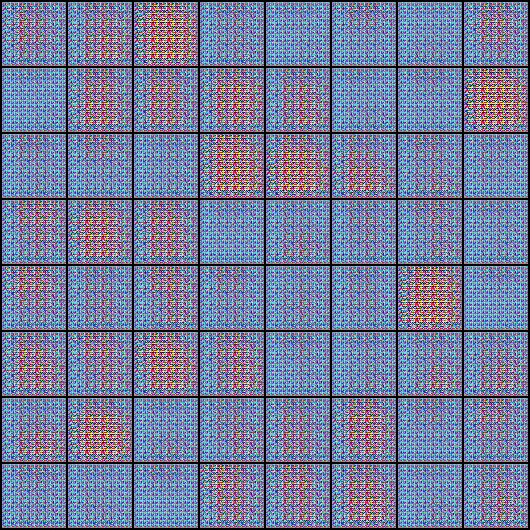

In [40]:
Image('./generated/generated-images-0013.png')

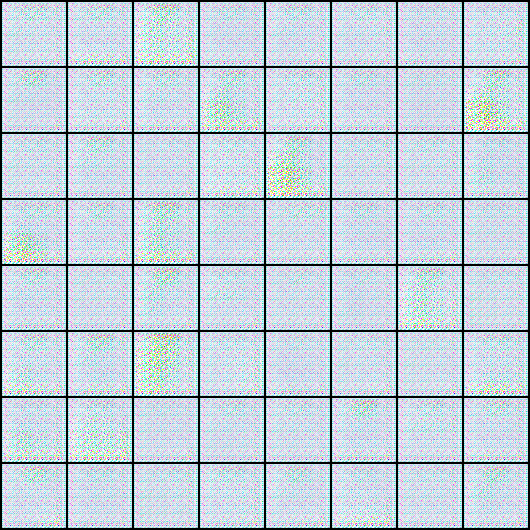

In [41]:
Image('./generated/generated-images-0037.png')

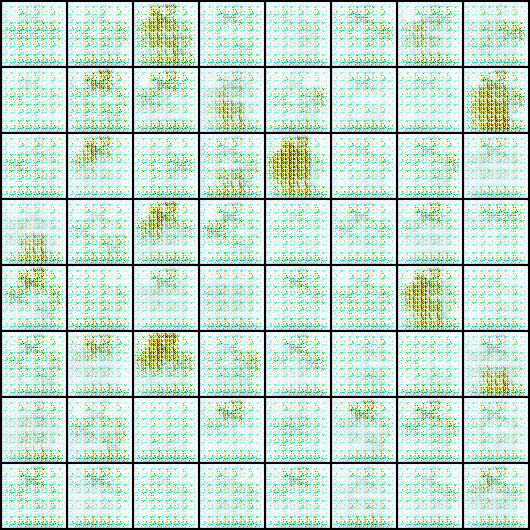

In [42]:
Image('./generated/generated-images-0072.png')

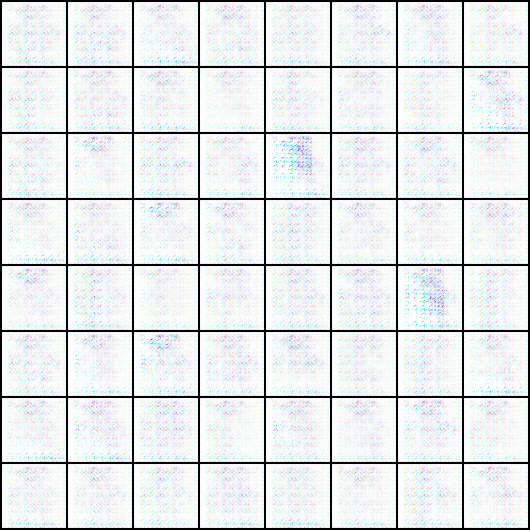

In [43]:
Image('./generated/generated-images-0103.png')

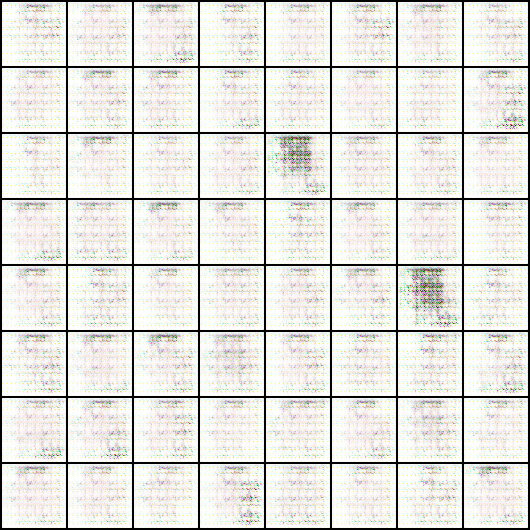

In [44]:
Image('./generated/generated-images-0138.png')

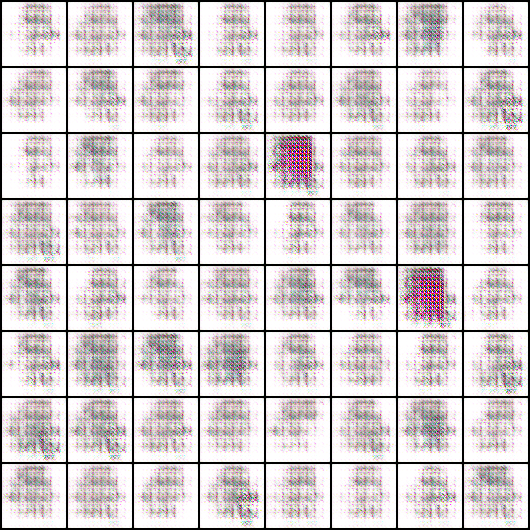

In [45]:
Image('./generated/generated-images-0147.png')

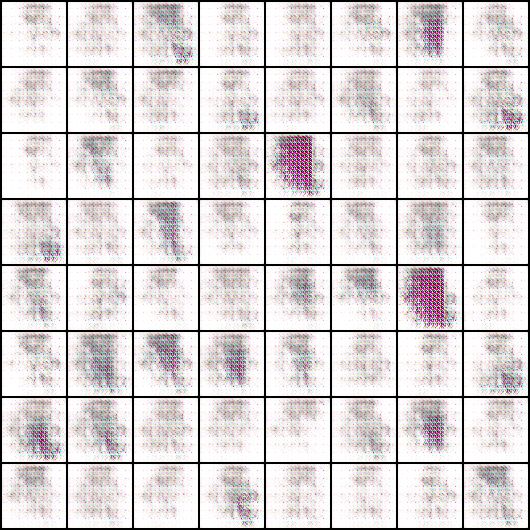

In [46]:
Image('./generated/generated-images-0150.png')

In [47]:
losses_g, losses_d, real_scores, fake_scores = history

In [48]:
jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

NameError: name 'jovian' is not defined

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()